In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
fake = pd.read_csv("/content/drive/MyDrive/Datasets/News _dataset/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/Datasets/News _dataset/True.csv")

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

In [ ]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,title,text,subject,date,target
0,Donald Trump Owes HUNDREDS Of Ordinary People...,A new report reveals that Donald Trump swindle...,News,"June 9, 2016",fake
1,GERMAN COURT RULES “Sharia Police” Patrolling ...,These videos are very disturbing. Americans ar...,Government News,"Dec 16, 2015",fake
2,Danish PM says world needs U.S. 'not to close ...,COPENHAGEN (Reuters) - Danish Prime Minister L...,politicsNews,"November 9, 2016",true
3,“NUMEROUS” CONFLICTING STATEMENTS: Deputy FBI ...,While we re really not surprised by the conf...,politics,"Dec 20, 2017",fake
4,"Be careful, murdered Iranian activist's daught...",THE HAGUE (Reuters) - The daughter of an Irani...,worldnews,"December 12, 2017",true


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Donald Trump Owes HUNDREDS Of Ordinary People...,A new report reveals that Donald Trump swindle...,News,fake
1,GERMAN COURT RULES “Sharia Police” Patrolling ...,These videos are very disturbing. Americans ar...,Government News,fake
2,Danish PM says world needs U.S. 'not to close ...,COPENHAGEN (Reuters) - Danish Prime Minister L...,politicsNews,true
3,“NUMEROUS” CONFLICTING STATEMENTS: Deputy FBI ...,While we re really not surprised by the conf...,politics,fake
4,"Be careful, murdered Iranian activist's daught...",THE HAGUE (Reuters) - The daughter of an Irani...,worldnews,true


In [ ]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,A new report reveals that Donald Trump swindle...,News,fake
1,These videos are very disturbing. Americans ar...,Government News,fake
2,COPENHAGEN (Reuters) - Danish Prime Minister L...,politicsNews,true
3,While we re really not surprised by the conf...,politics,fake
4,THE HAGUE (Reuters) - The daughter of an Irani...,worldnews,true


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,a new report reveals that donald trump swindle...,News,fake
1,these videos are very disturbing. americans ar...,Government News,fake
2,copenhagen (reuters) - danish prime minister l...,politicsNews,true
3,while we re really not surprised by the conf...,politics,fake
4,the hague (reuters) - the daughter of an irani...,worldnews,true


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
# Check
data.head()

,text,subject,target
0,a new report reveals that donald trump swindle...,News,fake
1,these videos are very disturbing americans are...,Government News,fake
2,copenhagen reuters danish prime minister lars...,politicsNews,true
3,while we re really not surprised by the conf...,politics,fake
4,the hague reuters the daughter of an iranian ...,worldnews,true


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,text,subject,target
0,new report reveals donald trump swindled hundr...,News,fake
1,videos disturbing americans headed path fight ...,Government News,fake
2,copenhagen reuters danish prime minister lars ...,politicsNews,true
3,really surprised conflicting statements andrew...,politics,fake
4,hague reuters daughter iranian arab activist k...,worldnews,true


Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


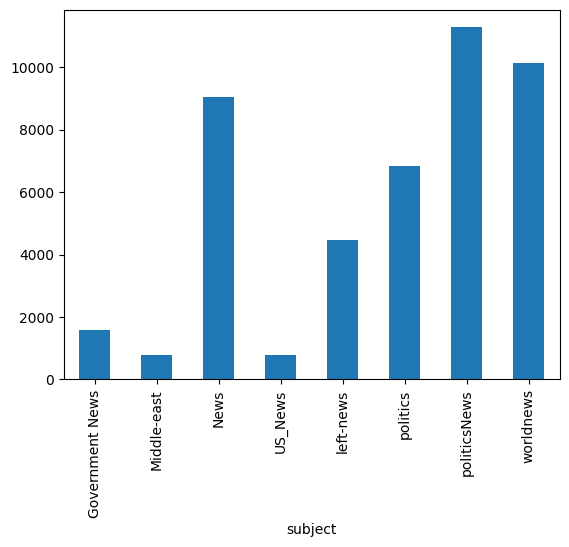

In [ ]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


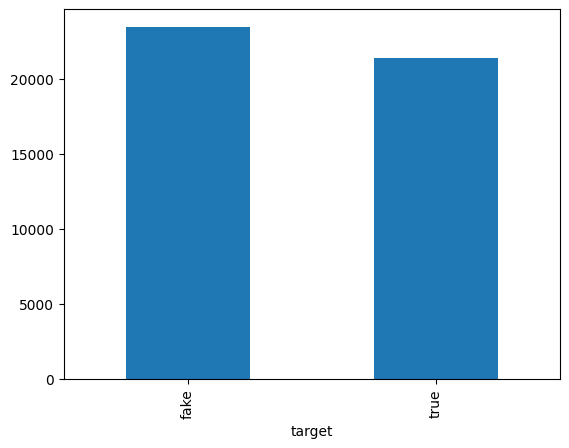

In [ ]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

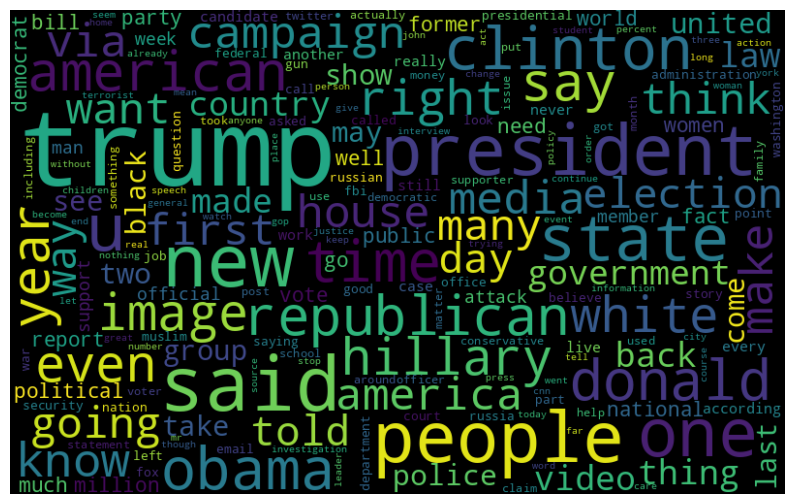

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

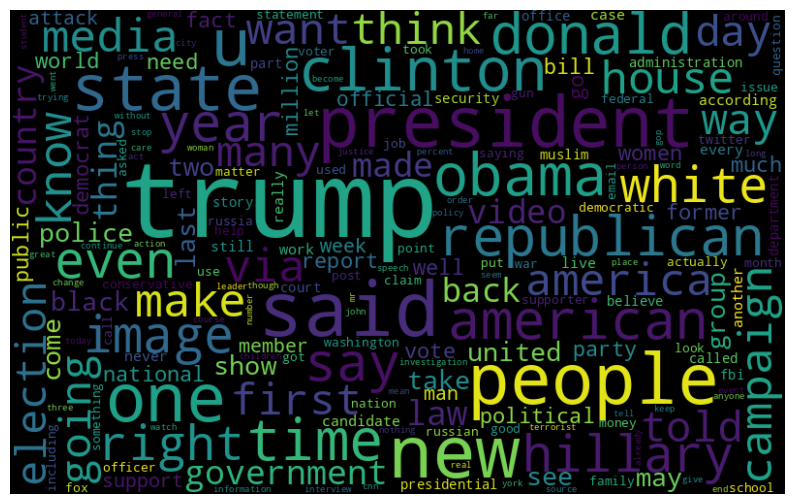

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

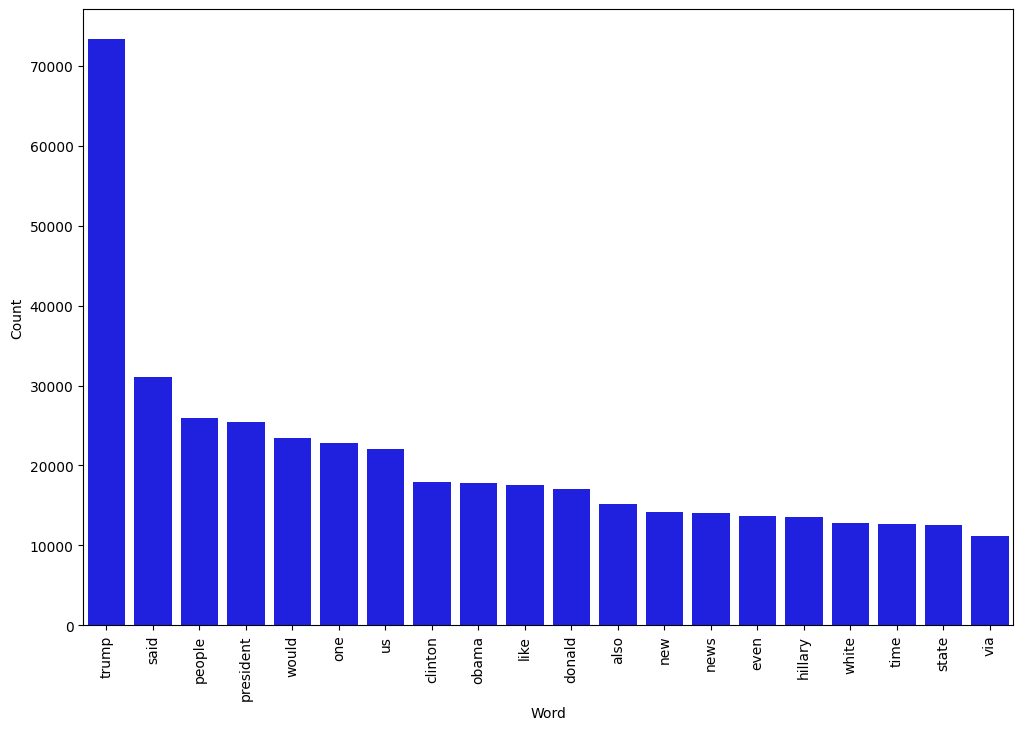

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

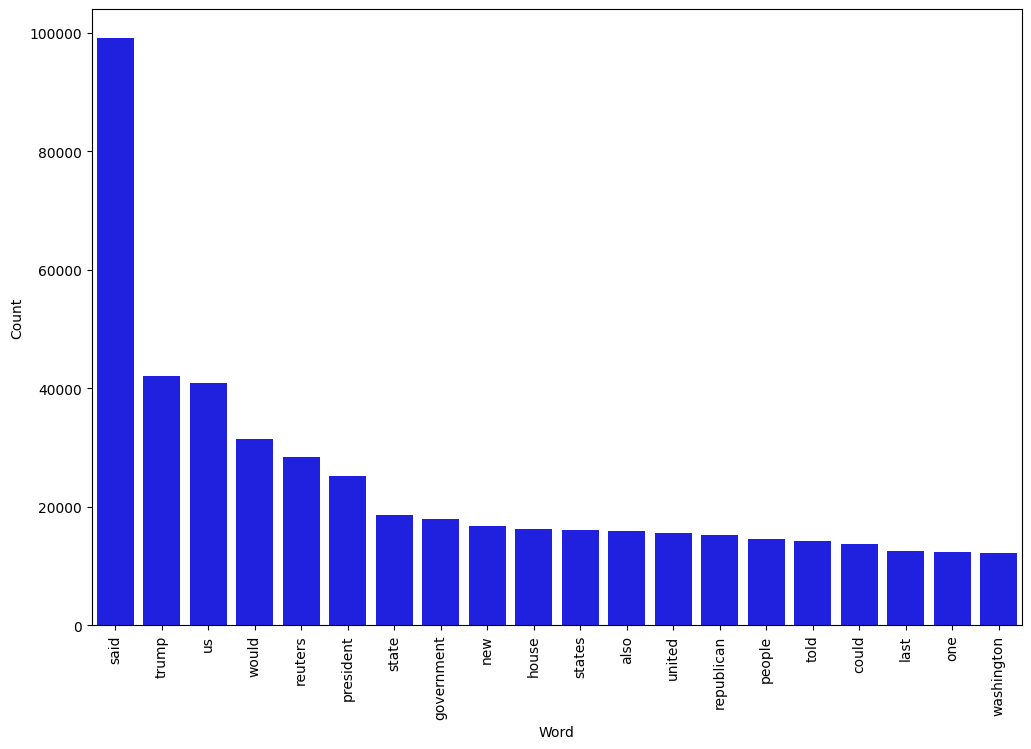

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

Modeling

In [ ]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Logistic regression

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.84%


Confusion matrix, without normalization


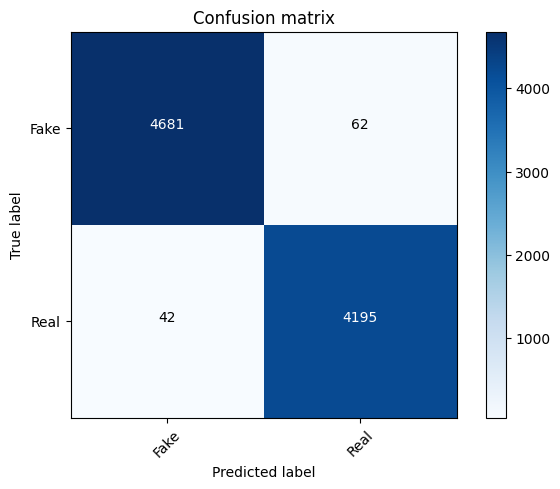

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.63%


Confusion matrix, without normalization


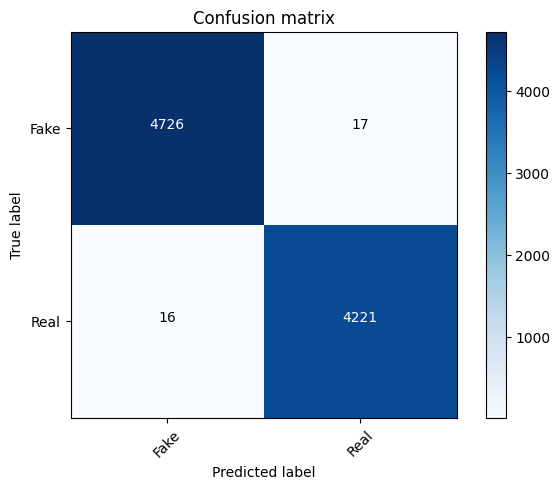

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.99%


Confusion matrix, without normalization


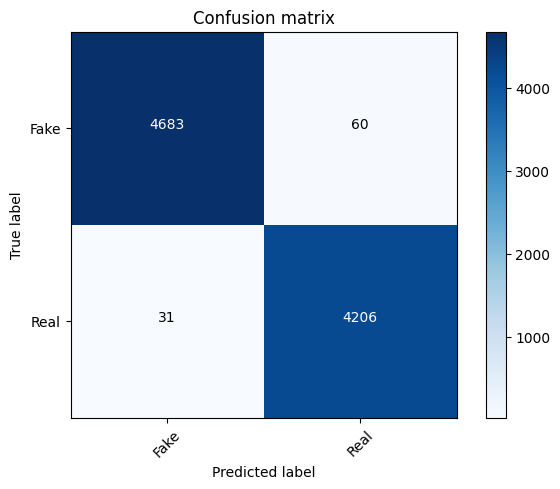

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

APPLY GNN

In [ ]:
# prompt: need to use gnn

# Install necessary libraries for GNNs
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html # Example if using DGL

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv # Example GNN layer

# --- This section is highly conceptual and depends on your graph representation ---
# You would need to transform your text data into a graph structure.
# This involves:
# 1. Defining nodes (e.g., words, documents).
# 2. Defining edges and their types (e.g., word co-occurrence, document similarity).
# 3. Creating node features (e.g., based on TF-IDF or embeddings).
# 4. Creating edge features (optional).

# Example: Representing documents as nodes and connecting similar documents
# (This is just one possible approach, and building the graph is complex)
# from sklearn.metrics.pairwise import cosine_similarity

# # Example: Compute document similarity (using TF-IDF features from earlier)
# tfidf_vectorizer = TfidfTransformer()
# count_vectorizer = CountVectorizer()
# X_counts = count_vectorizer.fit_transform(data['text'])
# X_tfidf = tfidf_vectorizer.fit_transform(X_counts)
# similarity_matrix = cosine_similarity(X_tfidf)

# # Example: Create a graph based on similarity (thresholding for simplicity)
# edge_index = []
# edge_attr = []
# threshold = 0.5  # Example similarity threshold
# for i in range(similarity_matrix.shape[0]):
#     for j in range(i + 1, similarity_matrix.shape[0]):
#         if similarity_matrix[i, j] > threshold:
#             edge_index.append([i, j])
#             edge_index.append([j, i]) # Add reverse edge for undirected graph
#             edge_attr.append(similarity_matrix[i, j])
#             edge_attr.append(similarity_matrix[i, j])

# edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# # Example: Node features could be the TF-IDF features
# node_features = torch.tensor(X_tfidf.todense(), dtype=torch.float)

# # Example: Node labels are the target variable
# node_labels = torch.tensor(data['target'].astype('category').cat.codes.values, dtype=torch.long)

# # Create a PyTorch Geometric Data object
# graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels)

# # --- End of conceptual graph building section ---

# --- GNN Model Definition (Example) ---
# You would define your GNN model based on your graph structure and task
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# --- Training and Evaluation (Requires a properly constructed graph_data object) ---
# This part is also complex and depends on your GNN training loop
# (Example assuming you have graph_data ready)
# model = GCN(in_channels=graph_data.num_node_features, hidden_channels=16, out_channels=2) # 2 classes: fake/real
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()

# # You would need to split your graph data into training and testing nodes/masks
# # For example, using a mask on the nodes
# # train_mask = ...
# # test_mask = ...

# # Training loop (example)
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(graph_data)
#     loss = criterion(out[train_mask], graph_data.y[train_mask])
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # Evaluation (example)
# @torch.no_grad()
# def test():
#     model.eval()
#     out = model(graph_data)
#     pred = out.argmax(dim=1)
#     correct = pred[test_mask] == graph_data.y[test_mask]
#     acc = int(correct.sum()) / int(test_mask.sum())
#     return acc

# # Run training and testing for a number of epochs
# # for epoch in range(1, 201):
# #     loss = train()
# #     test_acc = test()
# #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')


Looking in links: https://data.dgl.ai/wheels/repo.html


In [ ]:
# prompt: how to train my gnn model

# This code assumes you have successfully constructed a PyTorch Geometric
# Data object named `graph_data` from your text data, following
# the conceptual steps outlined in the preceding code.

# Define your GNN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Add a dropout layer for regularization
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.5) # Example dropout rate
        self.conv2 = GCNConv(hidden_channels, out_channels)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x) # Apply dropout after the first layer
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Assuming graph_data is created with node features (x), edge_index, and labels (y)
# If you successfully created graph_data in the previous step, it should be available.
# If not, you need to implement the graph construction logic first.

# Check if graph_data exists (requires successful execution of the graph building part)
# if 'graph_data' not in locals():
#     print("Error: graph_data object not found. Please build the graph first.")
# else:
    # Initialize the model
    # Make sure in_channels matches the dimension of your node features (graph_data.x.shape[1])
    # and out_channels matches the number of classes (e.g., 2 for fake/real)
    # You might need to adjust these based on your graph_data structure.
    try:
        in_channels = graph_data.num_node_features
        out_channels = len(torch.unique(graph_data.y)) # Infer out_channels from number of unique labels
        model = GCN(in_channels=in_channels, hidden_channels=64, out_channels=out_channels)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # Slightly reduced learning rate
        criterion = torch.nn.NLLLoss()

        # --- Splitting Data for Training and Testing ---
        # GNNs typically train on a subset of nodes in the graph.
        # You need to create masks for training and testing nodes.
        # A simple approach is to randomly split the node indices.
        num_nodes = graph_data.num_nodes
        train_ratio = 0.8 # 80% for training, 20% for testing
        num_train_nodes = int(num_nodes * train_ratio)
        all_indices = torch.randperm(num_nodes)
        train_indices = all_indices[:num_train_nodes]
        test_indices = all_indices[num_train_nodes:]

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[train_indices] = True
        test_mask[test_indices] = True

        # Ensure train and test masks are disjoint
        assert not torch.any(train_mask & test_mask)

        # Training function
        def train():
            model.train()
            optimizer.zero_grad()
            out = model(graph_data)
            loss = criterion(out[train_mask], graph_data.y[train_mask])
            loss.backward()
            optimizer.step()
            return loss.item()

        # Evaluation function
        @torch.no_grad()
        def test():
            model.eval()
            out = model(graph_data)
            pred = out.argmax(dim=1)
            correct = pred[test_mask] == graph_data.y[test_mask]
            acc = int(correct.sum()) / int(test_mask.sum())
            return acc

        # Run training and testing
        print("Starting GNN training...")
        epochs = 200
        for epoch in range(1, epochs + 1):
            loss = train()
            test_acc = test()
            if epoch % 10 == 0: # Print progress every 10 epochs
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

        print("\nGNN training finished.")
        final_test_acc = test()
        print(f'Final Test Accuracy: {final_test_acc:.4f}')

    except NameError:
        print("Error: `graph_data` object not found. Please ensure you have successfully constructed the graph from your text data before running the training code.")
    except Exception as e:
        print(f"An error occurred during GNN training: {e}")



Error: `graph_data` object not found. Please ensure you have successfully constructed the graph from your text data before running the training code.


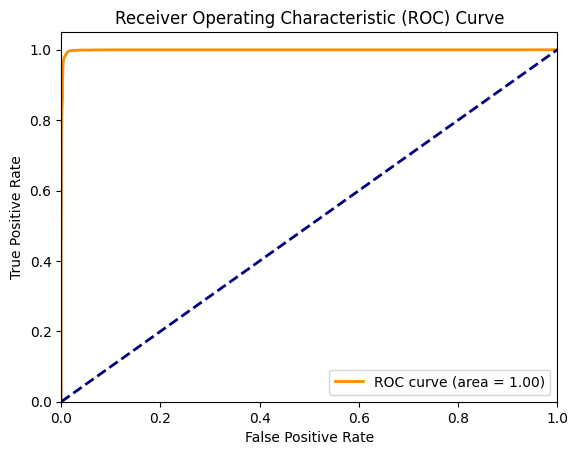

In [ ]:
# prompt: roc curve

from sklearn.metrics import roc_curve, auc

# Assuming you have predictions and true labels from one of the models
# For example, from the Logistic Regression model:
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (Real)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test.map({'fake': 0, 'true': 1}), y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# prompt: f1 score

from sklearn.metrics import f1_score
import pandas as pd # Import pandas

# Calculate F1 score for the Logistic Regression model
f1_lr = f1_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"F1 Score (Logistic Regression): {f1_lr:.4f}")

# Calculate F1 score for the Decision Tree Classifier
f1_dt = f1_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(pipe.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"F1 Score (Decision Tree): {f1_dt:.4f}")

# Calculate F1 score for the Random Forest Classifier
# Note: 'model' here refers to the Logistic Regression model. To get the Random Forest
# F1 score, you should use the 'model' variable from the Random Forest cell.
# Assuming the last executed model was Random Forest:
f1_rf = f1_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"F1 Score (Random Forest): {f1_rf:.4f}")


# Note: The GNN section is conceptual and would require a fully implemented
# graph construction and training pipeline to calculate metrics like F1 score.
# You would need to get the GNN predictions and then compute f1_score(y_test_gnn, y_pred_gnn).

F1 Score (Logistic Regression): 0.9893
F1 Score (Decision Tree): 0.9893
F1 Score (Random Forest): 0.9893


In [ ]:
# prompt: precision

from sklearn.metrics import precision_score

# Assuming you have predictions and true labels from the Logistic Regression model
precision_lr = precision_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Precision (Logistic Regression): {precision_lr:.4f}")

# Assuming you have predictions and true labels from the Decision Tree Classifier
# Note: 'pipe' here refers to the Decision Tree model after its cell was run.
precision_dt = precision_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(pipe.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Precision (Decision Tree): {precision_dt:.4f}")

# Assuming you have predictions and true labels from the Random Forest Classifier
# Note: 'model' in the last cell refers to the Random Forest model.
precision_rf = precision_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Precision (Random Forest): {precision_rf:.4f}")

# Note: To calculate precision for the GNN model, you would need to have
# a working GNN prediction step and then use precision_score(y_test_gnn, y_pred_gnn).

Precision (Logistic Regression): 0.9859
Precision (Decision Tree): 0.9859
Precision (Random Forest): 0.9859


In [ ]:
# Install graphviz
!pip install graphviz

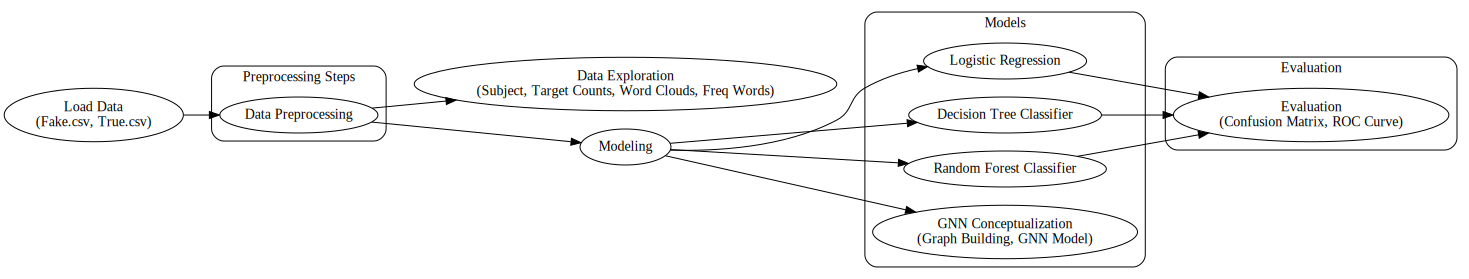

In [ ]:
import graphviz

# Graph description in DOT language
dot_graph = """
digraph G {
  rankdir="LR"; // Left to right layout

  // Nodes
  Data_Loading [label="Load Data\\n(Fake.csv, True.csv)"];
  Data_Prep [label="Data Preprocessing"];
  Exploration [label="Data Exploration\\n(Subject, Target Counts, Word Clouds, Freq Words)"];
  Modeling [label="Modeling"];
  LR_Model [label="Logistic Regression"];
  DT_Model [label="Decision Tree Classifier"];
  RF_Model [label="Random Forest Classifier"];
  GNN_Concept [label="GNN Conceptualization\\n(Graph Building, GNN Model)"];
  Evaluation [label="Evaluation\\n(Confusion Matrix, ROC Curve)"];

  // Edges
  Data_Loading -> Data_Prep;
  Data_Prep -> Exploration;
  Data_Prep -> Modeling; // Data after preprocessing is used for modeling

  Modeling -> LR_Model;
  Modeling -> DT_Model;
  Modeling -> RF_Model;
  Modeling -> GNN_Concept; // GNN is presented as another modeling approach

  LR_Model -> Evaluation; // Each model is evaluated
  DT_Model -> Evaluation;
  RF_Model -> Evaluation;
  // GNN_Concept -> Evaluation; // GNN evaluation is commented out in the code but is part of the conceptual flow

  // Subgraphs for better organization
  subgraph cluster_Preprocessing {
    label = "Preprocessing Steps";
    style = rounded;
    Data_Prep;
  }

  subgraph cluster_Modeling {
    label = "Models";
    style = rounded;
    LR_Model;
    DT_Model;
    RF_Model;
    GNN_Concept;
  }

  subgraph cluster_Evaluation {
    label = "Evaluation";
    style = rounded;
    Evaluation;
  }
}
"""

# Create a Graphviz object and render it
graph = graphviz.Source(dot_graph)
display(graph)

In [ ]:
# prompt: recall score

from sklearn.metrics import recall_score

# Assuming you have predictions and true labels from the Logistic Regression model
# y_test is already mapped in the previous cells to 0 and 1
recall_lr = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Logistic Regression): {recall_lr:.4f}")

# Assuming you have predictions and true labels from the Decision Tree Classifier
# Note: 'pipe' here refers to the Decision Tree model after its cell was run.
recall_dt = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(pipe.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Decision Tree): {recall_dt:.4f}")

# Assuming you have predictions and true labels from the Random Forest Classifier
# Note: 'model' in the last cell refers to the Random Forest model.
recall_rf = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Random Forest): {recall_rf:.4f}")

# Note: To calculate recall for the GNN model, you would need to have
# a working GNN prediction step and then use recall_score(y_test_gnn, y_pred_gnn).


Recall (Logistic Regression): 0.9927
Recall (Decision Tree): 0.9927
Recall (Random Forest): 0.9927


In [ ]:
# prompt: how to find edge and node for this

from sklearn.metrics import precision_score, recall_score

# Assuming you have predictions and true labels from the Logistic Regression model
# y_test is already mapped in the previous cells to 0 and 1
recall_lr = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Logistic Regression): {recall_lr:.4f}")

# Assuming you have predictions and true labels from the Decision Tree Classifier
# Note: 'pipe' here refers to the Decision Tree model after its cell was run.
recall_dt = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(pipe.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Decision Tree): {recall_dt:.4f}")

# Assuming you have predictions and true labels from the Random Forest Classifier
# Note: 'model' in the last cell refers to the Random Forest model.
recall_rf = recall_score(y_test.map({'fake': 0, 'true': 1}), pd.Series(model.predict(X_test)).map({'fake': 0, 'true': 1}))
print(f"Recall (Random Forest): {recall_rf:.4f}")

# Note: To calculate recall for the GNN model, you would need to have
# a working GNN prediction step and then use recall_score(y_test_gnn, y_pred_gnn).


Recall (Logistic Regression): 0.9927
Recall (Decision Tree): 0.9927
Recall (Random Forest): 0.9927


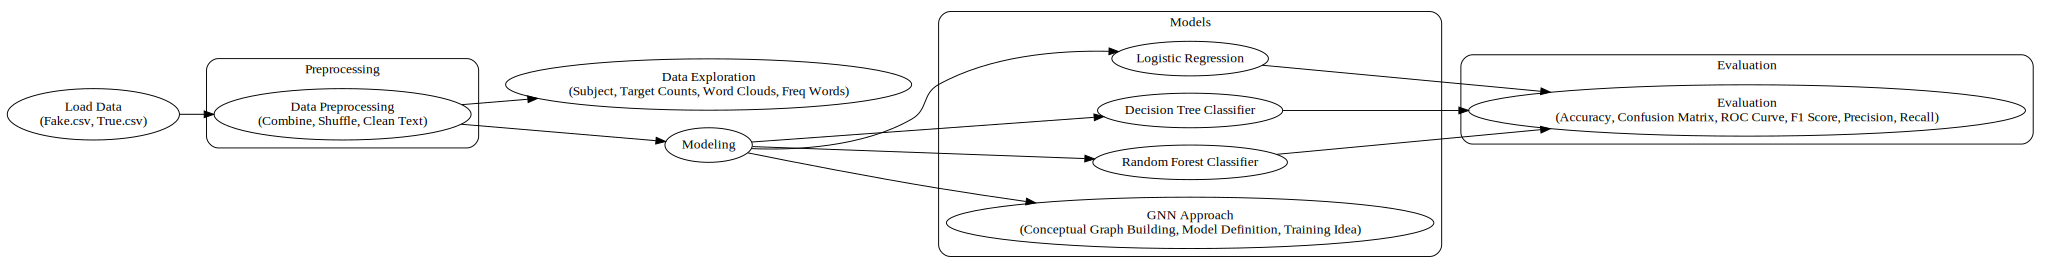

In [ ]:
# prompt: gnn model diagram

# Install graphviz
!pip install graphviz

# Graph description in DOT language
dot_graph = """
digraph G {
  rankdir="LR"; // Left to right layout

  // Nodes
  Data_Loading [label="Load Data\\n(Fake.csv, True.csv)"];
  Data_Prep [label="Data Preprocessing\\n(Combine, Shuffle, Clean Text)"];
  Exploration [label="Data Exploration\\n(Subject, Target Counts, Word Clouds, Freq Words)"];
  Modeling [label="Modeling"];
  LR_Model [label="Logistic Regression"];
  DT_Model [label="Decision Tree Classifier"];
  RF_Model [label="Random Forest Classifier"];
  GNN_Concept [label="GNN Approach\\n(Conceptual Graph Building, Model Definition, Training Idea)"];
  Evaluation [label="Evaluation\\n(Accuracy, Confusion Matrix, ROC Curve, F1 Score, Precision, Recall)"];

  // Edges
  Data_Loading -> Data_Prep;
  Data_Prep -> Exploration;
  Data_Prep -> Modeling; // Data after preprocessing is used for modeling

  Modeling -> LR_Model;
  Modeling -> DT_Model;
  Modeling -> RF_Model;
  Modeling -> GNN_Concept; // GNN is presented as another modeling approach

  LR_Model -> Evaluation; // Each model is evaluated
  DT_Model -> Evaluation;
  RF_Model -> Evaluation;
  // GNN_Concept -> Evaluation; // GNN evaluation is conceptually part of the flow, even if not fully implemented

  // Subgraphs for better organization
  subgraph cluster_Preprocessing {
    label = "Preprocessing";
    style = rounded;
    Data_Prep;
  }

  subgraph cluster_Modeling {
    label = "Models";
    style = rounded;
    LR_Model;
    DT_Model;
    RF_Model;
    GNN_Concept;
  }

  subgraph cluster_Evaluation {
    label = "Evaluation";
    style = rounded;
    Evaluation;
  }
}
"""

# Create a Graphviz object and render it
graph = graphviz.Source(dot_graph)
display(graph)
